In [2]:
from typing import Any, Callable, List, Optional, Tuple, Dict
import json, sys
import numpy as np
import pandas as pd
import os
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from utils.env_utils import keep_only_core_observations, keep_only_electrical_storage

print('Python:', sys.version.split()[0])
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-09-22 22:34:19.366795: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-22 22:34:19.380722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758573259.395566  496999 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758573259.399751  496999 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758573259.411167  496999 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
CityLearn: 2.4.1


In [19]:
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/rbc0'
RBC_LOG_FILE = os.path.join(LOG_DIR, "rbc0_agent_logs_10episodes.csv")
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'
ACTION_LABELS = ['discharge_full','discharge_half','idle','charge_half','charge_full']
NAME_TO_FRAC = {
    'discharge_full': -1.0,
    'discharge_half': -0.5,
    'idle': 0.0,
    'charge_half': 0.5,
    'charge_full': 1.0,
}
INT_TO_FRAC = np.array([NAME_TO_FRAC[n] for n in ACTION_LABELS], dtype=np.float32)

In [11]:
class RBCAgent:
    def __init__(self, 
                    obs_keys: List[str], # ['soc', 'price', 'net_load', 'solar_generation']
                    action_space: List[str], # ['charge', 'discharge', 'idle'] 
                    rule_defs: List[Dict] = None, 
                    # e.g. [
                    #   {
                    #     "conditions": [
                    #       {"field":"soc","op":"<","threshold_name":"soc_low"}
                    #     ],
                    #     "action":"charge"
                    #   }
                    # ]
                    thresholds: Dict[str, float] = None, # {'soc': 0.2, 'price': 50.0}
                    history: List[Tuple[Dict[str, float], str, float]] = None, # [(observation_dict, action_str, reward_float)]
                    obs_index_map: Optional[Dict[str, int]] = None):   # <--- NEW (optional)
        self.obs_keys = obs_keys
        self.action_space = action_space
        self.rule_defs = rule_defs or []
        self.thresholds = thresholds or {}
        self.history = history or []
        self.rewards = []
        self.obs_index_map = obs_index_map or {}                   # <--- NEW

        # Initialize rules from dictionaries
        self.rules = [(self.make_rule_fn(rule), rule["action"]) for rule in self.rule_defs]

    def set_obs_index_map(self, mapping: Dict[str, int]):          
        self.obs_index_map = dict(mapping)

    def _ensure_obs_map(self, env):                                 
        if self.obs_index_map:
            return
        names = getattr(env.buildings[0], "active_observations", None)
        if not names:
            raise RuntimeError(
                "obs_index_map missing and env has no observation_names. "
                "Call agent.set_obs_index_map({'soc': i, 'price': j, 'net_load': k, 'solar_generation': m})."
            )
        name_to_idx = {n: i for i, n in enumerate(names)}
        # default aliases
        wanted = {
            "soc": "electrical_storage_soc",
            "price": "electricity_pricing",
            "net_load": "net_electricity_consumption",  # or 'non_shiftable_load'
            "solar_generation": "solar_generation",
        }
        try:
            self.obs_index_map = {k: name_to_idx[wanted[k]] for k in self.obs_keys}
        except KeyError as e:
            raise RuntimeError(
                f"Could not auto-map {e}. "
                f"Available names include: {names[:20]} ..."
            )
    
    def add_rule(self, rule: dict):
        self.rule_defs.append(rule)
        cond_fn = self.make_rule_fn(rule)
        self.rules.append((cond_fn, rule['action']))
    
    def add_threshold(self, name: str, value: float):
        self.thresholds[name] = value
    
    def make_rule_fn(self, rule: Dict[str, Any]) -> Callable[[Dict[str, float]], bool]:
        """
        Create a condition function based on the rule dictionary.
        """
        cond_fns = []
        for cond in rule["conditions"]:
            field, op, threshold_name = cond["field"], cond["op"], cond["threshold_name"]
            if field not in self.obs_keys:
                raise ValueError(f"Field '{field}' not found in observation keys.")
            if threshold_name not in self.thresholds:
                raise ValueError(f"Threshold name '{threshold_name}' not found in thresholds.")
            if op == "<": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] < self.thresholds[t])
            elif op == "<=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] <= self.thresholds[t])
            elif op == ">": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] > self.thresholds[t])
            elif op == ">=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] >= self.thresholds[t])
            else: raise ValueError(f"Unsupported operator: {op}")
        return lambda obs: all(fn(obs) for fn in cond_fns)
    
    def act(self, observation)-> str:
        """
        Determine the action to take based on the current observation.
        If no rules match, return "idle".
        """
        for condition, action in self.rules:
            if condition(observation):
                return action
        return "idle"
    
    def save(self, filename="rbc_agent.json"):
        agent_state = {
            'obs_keys': self.obs_keys,
            'action_space': self.action_space,
            'rules': self.rule_defs,
            'thresholds': self.thresholds,
            'history': self.history,
        }
        with open(filename, "w") as f:
            json.dump(agent_state, f, indent=2)
    
    def load(self, filename="rbc_agent.json"):
        with open(filename, "r") as f:
            state = json.load(f)
        self.obs_keys = state['obs_keys']
        self.action_space = state['action_space']
        self.thresholds = state['thresholds']
        self.history = state['history']
        self.rule_defs = state['rules']
        # Rebuild rules from dictionaries
        self.rules = [
            (self.make_rule_fn(rule), rule['action']) for rule in self.rule_defs
        ]
    
    def evaluate(self, env, broadcast=False,  max_steps=None) -> Tuple[float, List[Tuple[Dict[str, float], str, float]]]:
        """
        Evaluate the agent for one episode in the given environment.
        Returns (episode_reward, episode_history),
        where episode_history is a list of (obs_dict, action_str, step_reward).
        """
        env.reset()
        self._ensure_obs_map(env)
        episode_history = []
        episode_reward = 0.0
        steps = 0


        done = False
        while not done and (max_steps is None or steps < max_steps):
            # 1) Observations for all buildings -> take building 0 only
            obs_all = env.observations            # List[List[float]]
            obs_vec  = obs_all[0]                         # features of building 0
            #obs_dict = {k: float(b0[i]) for i, k in enumerate(self.obs_keys)}
            obs_dict = {k: float(obs_vec [self.obs_index_map[k]]) for k in self.obs_keys}

            b0 = env.buildings[0]
            ts = b0.time_step
            obs_soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
            obs_dict['soc'] = float(obs_soc)

            # 2) Decide action for building 0
            action = self.act(obs_dict)

            # map the string action to numeric fractions for each storage
            # charge → +1.0, idle → 0.0, discharge → -1.0
            frac_map = { 
                '100%_charge': 1.0, 
                '50%_charge': 0.5, 
                'idle': 0.0, 
                '50%_discharge': -0.5, 
                '100%_discharge': -1.0 } 
            frac = frac_map[action]
            
            # 3) Build central-agent action list: control b0, zeros elsewhere
            N = env.action_space[0].shape[0]

            if broadcast:
                actions = [[float(np.clip(frac, -1.0, 1.0))] * N]
            else:
                flat = [0.0] * N
                flat[0] = float(np.clip(frac, -1.0, 1.0))
                actions = [flat]

            # 4) Step the env and unpack
            obs_all, reward_list, terminated, truncated, _ = env.step(actions)

            # 5) Use only building 0's reward
            step_reward = float(reward_list[0])

            # 6) Log + accumulate
            #print(f"{obs_dict}, {action}, {step_reward}")
            episode_history.append((obs_dict, action, step_reward))
            self.history.append((obs_dict, action, step_reward))

            episode_reward += step_reward
            done = bool(terminated) or bool(truncated)

            steps += 1

        return episode_reward, episode_history
    
    def multiple_evaluation(self, env, episodes=10) -> Tuple[float, float]:
        """
        Evaluate the agent over multiple episodes and return the mean and std of rewards.
        """
        self.rewards = []
        self.histories = []
        for _ in range(episodes):
            print(f"Episode {_ + 1}/{episodes}")
            episode_reward, episode_history = self.evaluate(env)
            self.rewards.append(episode_reward)
            self.histories.append(episode_history)
        return self.rewards, self.histories

In [ ]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)  # Load schema for the dataset
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN # Set reward function

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema) # (fixes "Expected 18 actions but got 1")
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

five_level_actions = ['100%_charge', '50%_charge', 'idle', '50%_discharge', '100%_discharge']
five_level_rules=[
    # 100% charge: soc <= 0.20    
    {'conditions': [
        {'field':'soc','op':'<=','threshold_name':'soc_empty'}], 
        'action':'idle'},
    # 50% charge: 0.20 < soc <= 0.30    
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_empty'}], 
        'action':'idle'}
]
thresholds={
    'soc_empty': 0.2, 
    'soc_low': 0.3,
    'soc_mid': 0.55, 
    'soc_high': 0.8, 
    'price': 0.04, 
}
env = CityLearnEnv(schema, central_agent=True)
agent = RBCAgent(obs_keys=['soc', 'price', 'net_load', 'solar_generation'],
                 action_space=five_level_actions,
                 rule_defs=five_level_rules,
                 thresholds=thresholds,
                 history=[])


"""
0: day_type
1: hour
2: outdoor_dry_bulb_temperature
3: outdoor_dry_bulb_temperature_predicted_1
4: outdoor_dry_bulb_temperature_predicted_2
5: outdoor_dry_bulb_temperature_predicted_3
6: diffuse_solar_irradiance
7: diffuse_solar_irradiance_predicted_1
8: diffuse_solar_irradiance_predicted_2
9: diffuse_solar_irradiance_predicted_3
10: direct_solar_irradiance
11: direct_solar_irradiance_predicted_1
12: direct_solar_irradiance_predicted_2
13: direct_solar_irradiance_predicted_3
14: carbon_intensity
15: indoor_dry_bulb_temperature
16: non_shiftable_load
17: solar_generation
18: dwh_storage_soc
19: electrical_storage_soc
20: net_electricity_consumption
21: electricity_pricing
22: electricity_pricing_predicted_1
23: electricity_pricing_predicted_2
24: electricity_pricing_predicted_3
25: cooling demand
26: dwh demand
27: occupant count
28: power_outage
29: indoor_dry_bulb_temperature_cooling_set_point
"""

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-22_22-35-42'


'\n0: day_type\n1: hour\n2: outdoor_dry_bulb_temperature\n3: outdoor_dry_bulb_temperature_predicted_1\n4: outdoor_dry_bulb_temperature_predicted_2\n5: outdoor_dry_bulb_temperature_predicted_3\n6: diffuse_solar_irradiance\n7: diffuse_solar_irradiance_predicted_1\n8: diffuse_solar_irradiance_predicted_2\n9: diffuse_solar_irradiance_predicted_3\n10: direct_solar_irradiance\n11: direct_solar_irradiance_predicted_1\n12: direct_solar_irradiance_predicted_2\n13: direct_solar_irradiance_predicted_3\n14: carbon_intensity\n15: indoor_dry_bulb_temperature\n16: non_shiftable_load\n17: solar_generation\n18: dwh_storage_soc\n19: electrical_storage_soc\n20: net_electricity_consumption\n21: electricity_pricing\n22: electricity_pricing_predicted_1\n23: electricity_pricing_predicted_2\n24: electricity_pricing_predicted_3\n25: cooling demand\n26: dwh demand\n27: occupant count\n28: power_outage\n29: indoor_dry_bulb_temperature_cooling_set_point\n'

#### Evaluation

In [20]:
# 10-fache Evaluation statt single evaluate
import numpy as np

try:
    rewards, histories = agent.multiple_evaluation(env, episodes=10)
except AttributeError:
    # Fallback: falls multiple_evaluation fehlt -> 1 Episode
    r, hist = agent.evaluate(env)
    rewards, histories = [r], [hist]

print(f"Episodes: {len(histories)} | mean reward: {np.mean(rewards):.3f} | per-episode: {np.round(rewards, 3)}")

Episode 1/10
Episode 2/10
Episode 3/10
Episode 4/10
Episode 5/10
Episode 6/10
Episode 7/10
Episode 8/10
Episode 9/10
Episode 10/10
Episodes: 10 | mean reward: -1584.091 | per-episode: [-1584.091 -1584.091 -1584.091 -1584.091 -1584.091 -1584.091 -1584.091
 -1584.091 -1584.091 -1584.091]


In [13]:
print('Reward function:', type(env.reward_function).__name__)
try:
    from citylearn.citylearn import CityLearnEnv

    def _unwrap_to_citylearn(e):
        cur, seen = e, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        raise RuntimeError("CityLearnEnv not found inside wrappers.")

    _base = _unwrap_to_citylearn(env)
    print(_base.schema['buildings'][_base.buildings[0].name]['pricing'])
except Exception as ex:
    print("Pricing info unavailable:", ex)

Reward function: CostReward
pricing_germany_2023_june_to_august.csv


In [14]:
import numpy as np
from citylearn.citylearn import CityLearnEnv

def unwrap_to_citylearn(e):
    cur, seen = e, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

def replay_hist_and_capture(env, hist, building_idx=0, broadcast=False):
    """Replays ONE episode's history and returns true arrays per step."""
    base = unwrap_to_citylearn(env)
    base.reset()
    b = base.buildings[building_idx]
    N = base.action_space[0].shape[0]

    NAME_TO_FRAC = {'discharge_full':-1.0,'discharge_half':-0.5,'idle':0.0,'charge_half':0.5,'charge_full':1.0}

    net_true, nsl_true, price_true, solar_true = [], [], [], []
    for obs_dict, action_name, _ in hist:
        frac = float(np.clip(NAME_TO_FRAC.get(action_name, 0.0), -1.0, 1.0))
        if broadcast:
            act = [float(frac)] * N
        else:
            act = [0.0] * N
            act[0] = float(frac)

        base.step([act])

        ts_now = b.time_step
        ts_idx = max(0, ts_now - 1)

        net_now = float(b.net_electricity_consumption[ts_now])
        net_idx = float(b.net_electricity_consumption[ts_idx])
        net_true.append(net_idx if net_now == 0.0 else net_now)

        nsl_now = float(b.non_shiftable_load[ts_now])
        nsl_idx = float(b.non_shiftable_load[ts_idx])
        nsl_true.append(nsl_idx if nsl_now == 0.0 else nsl_now)

        price_true.append(float(b.pricing.electricity_pricing[ts_now]) if b.pricing is not None else np.nan)
        solar_true.append(float(b.solar_generation[ts_now]))

    return (np.array(net_true), np.array(nsl_true),
            np.array(price_true), np.array(solar_true))

In [ ]:
# ca x min
import pandas as pd
import numpy as np
import os

# RBC_LOG_FILE muss gesetzt sein (z. B. "logs/rbc_eval.csv")
assert 'RBC_LOG_FILE' in globals() and RBC_LOG_FILE, "Setze RBC_LOG_FILE auf einen Pfad."

# 1) Roh-Logs aus histories (NICHT agent.history)
all_rows = []
for ep_idx, hist in enumerate(histories):
    for t, (obs, action, reward) in enumerate(hist):
        row = {'episode': ep_idx, 'timestep': t, 'action': action, 'reward': reward}
        for k in ('soc', 'price', 'net_load', 'solar_generation'):
            if k in obs:
                row[k] = obs[k]
        all_rows.append(row)

df = pd.DataFrame(all_rows)

# fehlende Spalten konsistent anlegen
for col in ['soc','price','net_load','solar_generation','non_shiftable_load']:
    if col not in df.columns:
        df[col] = np.nan

# 2) Pro Episode echte Serien via Replay einsetzen
for ep_idx, hist in enumerate(histories):
    mask = df['episode'] == ep_idx
    steps = df.loc[mask, 'timestep'].values
    net_true, nsl_true, price_true, solar_true = replay_hist_and_capture(env, hist, building_idx=0, broadcast=False)
    L = min(len(steps), len(net_true))
    idx_take = steps[:L]
    sel = (df['episode'] == ep_idx) & (df['timestep'].isin(idx_take))
    df.loc[sel, 'net_load'] = net_true[:L]
    df.loc[sel, 'non_shiftable_load'] = nsl_true[:L]
    df.loc[sel, 'price'] = price_true[:L]
    df.loc[sel, 'solar_generation'] = solar_true[:L]

# 3) Speichern
cols = ['episode','timestep','soc','price','net_load','solar_generation','non_shiftable_load','action','reward']
cols = [c for c in cols if c in df.columns]
df = df[cols].sort_values(['episode','timestep']).reset_index(drop=True)

os.makedirs(os.path.dirname(RBC_LOG_FILE) or ".", exist_ok=True)
df.to_csv(RBC_LOG_FILE, index=False)

print(f"Wrote consolidated eval logs to {os.path.abspath(RBC_LOG_FILE)}")
print(f"Episodes: {len(histories)} | mean reward: {np.mean(rewards):.3f} | per-episode: {np.round(rewards,3)}")
print("Sanity check net_load:", float(np.nanmin(df['net_load'])), "to", float(np.nanmax(df['net_load'])))

In [15]:
# Attempt to load the log data, handle if file is missing
try:
    df = pd.read_csv(RBC_LOG_FILE)
except FileNotFoundError:
    print(f"Log file '{RBC_LOG_FILE}' not found.")

#### Plotting

In [21]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# ---- Konsistenz
df = df.sort_values(['episode','timestep']).reset_index(drop=True)
assert {'episode','timestep','net_load','price','solar_generation','non_shiftable_load','action','reward'}.issubset(df.columns)

# ---- DQN-Style: diskrete Action-Skala und Labels
INT_TO_FRAC = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
ACTION_LABELS = ['discharge_full','discharge_half','idle','charge_half','charge_full']

_int_map = {0:-1.0, 1:-0.5, 2:0.0, 3:0.5, 4:1.0}
_str_map = {'discharge_full':-1.0,'discharge_half':-0.5,'idle':0.0,'charge_half':0.5,'charge_full':1.0,
            'discharge-full':-1.0,'discharge-half':-0.5,'charge-half':0.5,'charge-full':1.0}

def actions_to_frac(series):
    s = series.copy()
    # Fall 1: Zahlen im Bereich [-1,1] (kontinuierlich)
    if np.issubdtype(s.dtype, np.number) and s.min()>=-1.0 and s.max()<=1.0:
        return s.clip(-1,1).astype(float)
    # Fall 2: Integer {0..4}
    if np.issubdtype(s.dtype, np.integer) and set(np.unique(s)).issubset(set(_int_map.keys())):
        return s.map(_int_map).astype(float)
    # Fall 3: Strings/Kategorien
    if s.dtype == 'O' or str(s.dtype).startswith('category'):
        return s.astype(str).str.lower().map(_str_map).fillna(0.0).astype(float)
    # Fallback
    return pd.to_numeric(s, errors='coerce').fillna(0.0).clip(-1,1)

# Action-Fraktionen Spalte (DQN-kompatibel)
df['action_frac'] = actions_to_frac(df['action']).astype(float)

# Für Verteilungen außerdem diskrete IDs 0..4 (matching INT_TO_FRAC)
frac_to_id = {v:i for i,v in enumerate(INT_TO_FRAC)}
df['action_id'] = df['action_frac'].map(lambda x: min(range(5), key=lambda i: abs(x-INT_TO_FRAC[i])))


# concat über alle Episoden (DQN macht das ebenfalls)
actions_frac_all = df['action_frac'].to_numpy()
hour_index = np.arange(len(actions_frac_all))
window = 500  # wie DQN

act_ma = pd.Series(actions_frac_all).rolling(window, min_periods=1).mean().to_numpy()

plt.figure(figsize=(7,3))
plt.scatter(hour_index, actions_frac_all, s=5, alpha=0.35, label='raw')  # DQN: default scatter
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'ma {window}')     # DQN: C2
plt.title('RBC Eval Actions over time (Raw + MA)')
plt.xlabel('Timestep'); plt.ylabel('Action [-1..1]')
plt.grid(True); plt.legend(loc='upper right')
plt.yticks(INT_TO_FRAC.tolist(), ACTION_LABELS)
plt.tight_layout(); plt.show()



plt.figure(figsize=(4,3))
counts = pd.Series(df['action_id']).value_counts().reindex(range(5)).fillna(0).astype(int)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])  # DQN: Farbliste
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({(v/total if total else 0):.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5 if counts.max()>0 else 1)
plt.ylabel('Count'); plt.title('Action Distribution')
plt.tight_layout(); plt.show()




def add_top_legend(ax_left, ax_right=None, ncol=3, y=1.50, top=0.84, loc='upper center', frameon=False):
    handles = []
    for ax in (ax_left, ax_right):
        if ax is None: 
            continue
        handles.extend(ax.get_lines())
    labels = [h.get_label() for h in handles]
    legend = ax_left.legend(handles, labels, loc=loc, bbox_to_anchor=(0.5, y), ncol=ncol, frameon=frameon)
    if top is not None:
        plt.subplots_adjust(top=top)
    return legend


# nimm erste Episode im Datensatz
ep0 = df['episode'].min()
df30 = df[df['episode']==ep0].head(30).copy()

t   = df30['timestep'].to_numpy()
net = df30['net_load'].to_numpy()
nsl = df30['non_shiftable_load'].to_numpy()
act = df30['action_frac'].to_numpy()

fig, ax1 = plt.subplots(figsize=(10.5, 3.6))
ax1.plot(t, net,  color='C4', marker='o', label='Net Load (with storage)')          # C4
ax1.plot(t, nsl,  color='C1', ls='--', marker='x', label='Non-shiftable Load')      # C1
ax1.set_xlabel('Timestep'); ax1.set_ylabel('Load')
ax1.set_xticks(t[::2])
ax1.set_ylim(-2, 4)
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.step(t, act, where='mid', color='C0', label='Action')                            # C0
ax2.set_ylabel('Action')
ax2.set_ylim(-1.1, 1.1)
ax2.set_yticks(INT_TO_FRAC.tolist()); ax2.set_yticklabels(ACTION_LABELS)

add_top_legend(ax1, ax2)
plt.title(f'RBC — first 30 steps — Episode {ep0}')
plt.tight_layout(); plt.show()




# Episode = erste im CSV
ep0 = df['episode'].min()
dfe = df[df['episode']==ep0].copy()
t = np.arange(len(dfe))

rewards = dfe['reward'].to_numpy(dtype=float)
net     = dfe['net_load'].to_numpy(dtype=float)
price   = dfe['price'].to_numpy(dtype=float)
solar   = dfe['solar_generation'].to_numpy(dtype=float)

window_reward = 24
window_x = 24
reward_ma = pd.Series(rewards).rolling(window_reward, min_periods=1).mean().to_numpy()
net_ma    = pd.Series(net).rolling(window_x, min_periods=1).mean().to_numpy()
price_ma  = pd.Series(price).rolling(window_x, min_periods=1).mean().to_numpy()
solar_ma  = pd.Series(solar).rolling(window_x, min_periods=1).mean().to_numpy()

# 5a) Reward vs Net Load
fig, ax1 = plt.subplots(figsize=(12, 3.5))
ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')  # C3
ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')        # C4
ax2.set_ylabel('Net Electricity Consumption', color='C4')
ax2.tick_params(axis='y', labelcolor='C4')

add_top_legend(ax1, ax2)
ax1.set_title(f'RBC Episode {ep0} — Reward vs Net Load')
plt.tight_layout(); plt.show()

# 5b) Reward vs Price
fig, ax1 = plt.subplots(figsize=(12, 3.5))
ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')  # C3
ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(t, price_ma, color='C0', label=f'Price MA (w=24)')                 # C0
ax2.set_ylabel('Electricity Price', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')

add_top_legend(ax1, ax2)
ax1.set_title(f'RBC Episode {ep0} — Reward vs Electricity Price')
plt.tight_layout(); plt.show()


# 5c) Reward vs Solar Generation
fig, ax1 = plt.subplots(figsize=(12, 3.5))
ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')  # C3
ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w=24)')             # C2
ax2.set_ylabel('Solar Generation', color='C2')
ax2.tick_params(axis='y', labelcolor='C2')

add_top_legend(ax1, ax2)
ax1.set_title(f'RBC Episode {ep0} — Reward vs Solar Generation')
plt.tight_layout(); plt.show()

KeyError: 'episode'

In [ ]:
# Experimental
def plot_first_30_steps_split_rbc(agent, env, building_name="Building_1"):
    """Three aligned panels: (1) actions + reward, (2) net & non-shiftable load + reward, (3) reward vs price (raw)."""
    base = unwrap_to_citylearn(env)
    bld_names = [b.name for b in base.buildings]
    if building_name not in bld_names:
        building_name = bld_names[0]
    b_idx = bld_names.index(building_name)

    # Reset and collect first 30 steps
    base.reset()
    t_list, net_list, nsl_list, act_frac_list, price_list, reward_list = [], [], [], [], [], []
    for t in range(30):
        # Minimal obs for rule eval
        obs_vec = base.observations[b_idx]
        obs_names_b = base.observation_names[b_idx]
        idx = {n: i for i, n in enumerate(obs_names_b)}
        b0 = base.buildings[b_idx]
        ts = b0.time_step
        soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
        obs_dict = {
            'soc': float(soc),
            'price': float(obs_vec[idx['electricity_pricing']]) if 'electricity_pricing' in idx else np.nan,
            'solar_generation': float(obs_vec[idx['solar_generation']]) if 'solar_generation' in idx else np.nan,
        }

        # Agent action -> fraction
        a_name = agent.act(obs_dict)
        a_frac = float(np.clip(NAME_TO_FRAC[a_name], -1.0, 1.0))

        # Central action vector (control first storage dim only)
        N = base.action_space[0].shape[0]
        flat = [0.0] * N
        flat[0] = a_frac

        # Step and capture reward
        _, rew, terminated, truncated, _ = base.step([flat])
        step_reward = float(rew[b_idx] if isinstance(rew, (list, tuple, np.ndarray)) else rew)

        # Read arrays (prefer non-zero for net load)
        ts_now = base.buildings[b_idx].time_step
        ts_idx = max(0, ts_now - 1)

        net_now = float(base.buildings[b_idx].net_electricity_consumption[ts_now])
        net_idx = float(base.buildings[b_idx].net_electricity_consumption[ts_idx])
        net_use = net_idx if net_now == 0.0 else net_now

        nsl_now = float(base.buildings[b_idx].non_shiftable_load[ts_now])
        nsl_idx = float(base.buildings[b_idx].non_shiftable_load[ts_idx])
        nsl_use = nsl_idx if nsl_now == 0.0 else nsl_now

        price_now = float(base.buildings[b_idx].pricing.electricity_pricing[ts_now]) if base.buildings[b_idx].pricing is not None else np.nan

        t_list.append(t)
        net_list.append(net_use)
        nsl_list.append(nsl_use)
        act_frac_list.append(a_frac)
        price_list.append(price_now)
        reward_list.append(step_reward)

        if bool(terminated) or bool(truncated):
            break

    # Arrays
    t = np.arange(len(t_list))
    net = np.asarray(net_list, dtype=float)
    nsl = np.asarray(nsl_list, dtype=float)
    act = np.asarray(act_frac_list, dtype=float)
    price = np.asarray(price_list, dtype=float)     # raw
    reward = np.asarray(reward_list, dtype=float)   # raw

    # Change markers where action changes
    change_idx = np.where(np.diff(act) != 0)[0]

    # Figure with 3 aligned panels (taller + more spacing)
    fig, axs = plt.subplots(3, 1, figsize=(12, 9.5), sharex=True, gridspec_kw={'hspace': 0.35})
    plt.subplots_adjust(right=0.82, top=0.92)  # leave room on right for legends

    # Panel 1: Actions (left, C5) + Reward (right, C0)
    ax1 = axs[0]
    lA = ax1.step(t, act, where='mid', color='C5', lw=2.0, label='Action')
    ax1.set_ylabel('Action', color='C5')
    ax1.tick_params(axis='y', colors='C5')
    ax1.spines['left'].set_color('C5')
    ax1.set_ylim(-1.1, 1.1)
    ax1.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    ax1.set_yticklabels(ACTION_LABELS)
    for x in change_idx:
        ax1.axvline(x=x + 0.5, color='k', ls=':', lw=0.8, alpha=0.25)
    ax1.set_title(f'RBC — first 30 steps — {building_name}', pad=10)

    ax1r = ax1.twinx()
    lR1 = ax1r.plot(t, reward, color='C0', lw=1.6, alpha=0.9, label='Reward')
    ax1r.set_ylabel('Reward', color='C0')
    ax1r.tick_params(axis='y', colors='C0')
    ax1r.spines['right'].set_color('C0')
    ax1.legend([lA[0], lR1[0]], ['Action', 'Reward'], loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=False)

    # Panel 2: Net (C4) & Non-shiftable (C4) + Reward (right, C0)
    ax2 = axs[1]
    lN = ax2.plot(t, net, color='C4', lw=2.0, marker='o', ms=4, label='Net Load')
    lB = ax2.plot(t, nsl, color='C4', lw=1.8, ls='--', marker='x', ms=5, label='Non-shiftable Load')
    ax2.set_ylabel('Load', color='C4')      # emphasize Net Load color
    ax2.tick_params(axis='y', colors='C4')
    ax2.spines['left'].set_color('C4')
    ax2.grid(True, which='both', axis='both', alpha=0.25)
    for x in change_idx:
        ax2.axvline(x=x + 0.5, color='k', ls=':', lw=0.8, alpha=0.15)

    ax2r = ax2.twinx()
    lR2 = ax2r.plot(t, reward, color='C0', lw=1.6, alpha=0.9, label='Reward')
    ax2r.set_ylabel('Reward', color='C0')
    ax2r.tick_params(axis='y', colors='C0')
    ax2r.spines['right'].set_color('C0')

    ax2.legend([lN[0], lB[0], lR2[0]], ['Net Load', 'Non-shiftable Load', 'Reward'],
               loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=False)

    # Panel 3: Price (left, C3) vs Reward (right, C0) — raw units
    ax3l = axs[2]
    l1 = ax3l.plot(t, price, color='C3', lw=1.8, label='Price')
    ax3l.set_ylabel('Electricity Price', color='C3')
    ax3l.tick_params(axis='y', colors='C3')
    ax3l.spines['left'].set_color('C3')
    ax3l.grid(True, axis='x', alpha=0.3)

    ax3r = ax3l.twinx()
    l2 = ax3r.plot(t, reward, color='C0', lw=1.8, label='Reward')
    ax3r.set_ylabel('Reward', color='C0')
    ax3r.tick_params(axis='y', colors='C0')
    ax3r.spines['right'].set_color('C0')

    # Combined legend (outside)
    lines = l1 + l2
    ax3l.legend(lines, [l.get_label() for l in lines], loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=False)

    for x in change_idx:
        ax3l.axvline(x=x + 0.5, color='k', ls=':', lw=0.8, alpha=0.15)

    axs[-1].set_xlabel('Timestep')
    axs[0].set_xticks(t[::2])

    plt.tight_layout()
    plt.show()

# Use the split version (raw price/reward)
plot_first_30_steps_split_rbc(agent=agent, env=env, building_name="Building_1")

In [7]:
b0 = env.buildings[0]
print("Active actions:", getattr(b0, "active_actions", None))
print("Battery capacity (kWh):", getattr(b0.electrical_storage, "capacity", None))
print("Battery max power (kW) if available:", getattr(b0.electrical_storage, "max_power", None))

# Ensure index 0 you’re setting really targets the battery:
names = getattr(env, "action_names", None)
if names:
    print("Action names per building[0]:", names[0])

Active actions: ['electrical_storage']
Battery capacity (kWh): 4.0
Battery max power (kW) if available: None
Action names per building[0]: ['electrical_storage', 'electrical_storage', 'electrical_storage', 'electrical_storage', 'electrical_storage', 'electrical_storage']


#### Cumulative Rewards

In [1]:
# === Cumulative Reward aus rbc_agent_logs_0.csv (eine Episode) ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pfad zur Logdatei

rbc_path = RBC_LOG_FILE

if not os.path.exists(rbc_path):
    raise FileNotFoundError(f"Logfile nicht gefunden: {os.path.abspath(rbc_path)}")

df = pd.read_csv(rbc_path)

# Reward-Spalte robust finden
reward_candidates = ["reward", "rewards", "step_reward", "step_rewards", "r"]
reward_col = next((c for c in reward_candidates if c in df.columns), None)
if reward_col is None:
    # Falls einzig numerische Spalte vorhanden ist, nimm die
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(num_cols) == 1:
        reward_col = num_cols[0]
    else:
        raise ValueError(f"Keine eindeutige Reward-Spalte gefunden. Spalten: {list(df.columns)}")

# Timestep/Index besorgen (optional)
t_candidates = ["timestep", "time_step", "t", "step", "index"]
t_col = next((c for c in t_candidates if c in df.columns), None)

# In float konvertieren und NaNs droppen
rew = pd.to_numeric(df[reward_col], errors="coerce").dropna().to_numpy()
if rew.size == 0:
    raise ValueError(f"Reward-Spalte '{reward_col}' enthält keine gültigen Zahlen.")

cum = np.cumsum(rew)
x = df[t_col].iloc[:len(rew)].to_numpy() if t_col else np.arange(len(rew))

plt.figure(figsize=(9, 4.5))
plt.plot(x, cum, lw=2)
plt.title("Cumulative Reward — evaluation episode 0")
plt.xlabel(t_col if t_col else "Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode length: {len(rew)} steps | Return: {cum[-1]:.3f}")

NameError: name 'RBC_LOG_FILE' is not defined

#### DecisionTree

[target] column='_target_action_id' (source='_derived_action_id', mode='factorized')
n_features: 4 sample: ['net_load', 'price', 'soc', 'solar_generation']
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single 

Best balanced_accuracy: 1.0
Best params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Surrogate Tree Accuracy: 1.000
Confusion matrix (rows=true, cols=pred):
 [[552]]
                precision    recall  f1-score   support

discharge_full       1.00      1.00      1.00       552

      accuracy                           1.00       552
     macro avg       1.00      1.00      1.00       552
  weighted avg       1.00      1.00      1.00       552


Top feature importances:
Exported SVG -> /hkfs/home/haicore/iai/cj9272/logs/rbc0/rbc_surrogate_tree.svg


/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single 

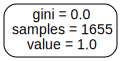

('/hkfs/home/haicore/iai/cj9272/logs/rbc0/rbc_surrogate_tree.svg', None)

In [ ]:
# ===================== RBC Surrogate Decision Tree (state -> action) =====================
# - Datei-Loader: CSV/TSV/JSON/JSONL (oder direkt DataFrame df_rbc)
# - Auto-Target-Erkennung; Diskretisierung für kontinuierliche Kommandos (symmetrisch um 0 bei ungeraden Bins)
# - Harte Leak-Filter (damit echte Zustands-Regeln entstehen)
# - GridSearchCV (balanced_accuracy), max_depth=5
# - Globale/regionale Erklärungen + SVG/PNG-Export

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ===================== Konfiguration =====================
DEFAULT_TEST_SIZE    = 0.25
DEFAULT_RANDOM_STATE = 0
DEFAULT_N_SPLITS     = 5
DEFAULT_BINS         = 5        # Diskretisierung bei kontinuierlichen Kommandos (z.B. Power-Setpoint)

# Optional: Pfade/Umgebung (kannst du oben im Notebook setzen)
RBC_LOG_FILE = globals().get("RBC_LOG_FILE", "")  # z.B. "path/to/rbc_log.csv"
LOG_DIR      = globals().get("LOG_DIR", ".")      # Speichert SVG/PNG hier

# Optional: eigene Labels/Mappings (falls diskrete Aktionen)
ACTION_LABELS = globals().get("ACTION_LABELS", ["discharge_full","discharge_half","idle","charge_half","charge_full"])
INT_TO_FRAC   = globals().get("INT_TO_FRAC",   [-1.0,-0.5,0.0,0.5,1.0])

# Kandidaten für diskrete Aktionsspalten
ACTION_ID_CANDIDATES = [
    "action_id", "rbc_action_id", "only_device_action_id",
    "act_id", "decision_id", "cmd_id", "power_cmd_id",
    "action", "act", "decision"
]
# Kandidaten für kontinuierliche Kommandos (falls keine IDs)
ACTION_CONT_CANDIDATES = [
    "command", "cmd", "power_cmd", "setpoint", "set_point",
    "power", "p_set", "p_cmd", "battery_power", "storage_power"
]

# Niemals als Features verwenden (Leaks/Meta)
EXPLICIT_DROP = {
    "global_step", "env_id", "episode", "step", "timestep",
    "reward", "done", "terminal", "truncate",
    "action_id", "rbc_action_id", "only_device_action_id",
    "action", "action_label", "action_frac",
    "act_id", "decision_id", "decision",
    "cmd_id", "power_cmd_id", "policy_action", "chosen_action"
}

# Verbotene Substrings (stärker als simple Prefix-Prüfung)
BAN_SUBSTR = (
    "action", "act", "cmd", "decision", "policy",
    "reward", "done", "terminal", "adv", "return", "value",
    "target", "future", "next_", "label", "y_", "gt_", "truth"
)

# ===================== Loader =====================
def read_any_log(path: str) -> pd.DataFrame:
    if not path or not os.path.exists(path):
        raise FileNotFoundError(f"Log file not found: {os.path.abspath(path) if path else path}")
    ext = os.path.splitext(path)[1].lower()
    if ext in (".csv", ".tsv"):
        try:
            return pd.read_csv(path)
        except Exception:
            return pd.read_csv(path, sep=None, engine="python")
    if ext in (".jsonl", ".ndjson"):
        rows = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line: continue
                try:
                    rows.append(json.loads(line))
                except json.JSONDecodeError:
                    rows.append(json.loads(line.rstrip(",")))
        return pd.DataFrame(rows)
    if ext == ".json":
        data = json.load(open(path, "r", encoding="utf-8"))
        if isinstance(data, list):
            return pd.DataFrame(data)
        if isinstance(data, dict) and "data" in data and isinstance(data["data"], list):
            return pd.DataFrame(data["data"])
        return pd.json_normalize(data)
    # Fallback CSV
    return pd.read_csv(path)

# ===================== Ziel-/Feature-Erkennung =====================
def _pick_action_column(df: pd.DataFrame):
    # 1) numerische ID-Kandidaten
    for c in ACTION_ID_CANDIDATES:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            return c, "id"
    # 2) Strings/Kategorien -> faktorisiere
    for c in ACTION_ID_CANDIDATES:
        if c in df.columns:
            ids, _ = pd.factorize(df[c])
            df["_derived_action_id"] = ids.astype(int)
            return "_derived_action_id", "factorized"
    # 3) kontinuierliche Kommandos
    for c in ACTION_CONT_CANDIDATES:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            return c, "continuous"
    # 4) Notlösung: Spaltenname enthält "action"
    for c in df.columns:
        if "action" in c.lower() and pd.api.types.is_numeric_dtype(df[c]):
            return c, "id"
    raise KeyError("Keine geeignete Aktionsspalte gefunden.")

def _discretize_if_needed(df: pd.DataFrame, col: str, mode: str, bins: int = DEFAULT_BINS):
    if mode in ("id", "factorized"):
        y = df[col].astype(int)
        k = int(y.max()) + 1 if y.min() == 0 else len(np.unique(y))
        # Labels aus Globals (optional)
        try:
            if ACTION_LABELS and len(ACTION_LABELS) >= k:
                class_names = list(ACTION_LABELS[:k])
            elif INT_TO_FRAC:
                mapping = {-1.0:"discharge_full",-0.5:"discharge_half",0.0:"idle",0.5:"charge_half",1.0:"charge_full"}
                class_names = [mapping.get(float(INT_TO_FRAC[i]), str(INT_TO_FRAC[i])) for i in range(k)]
            else:
                class_names = [str(i) for i in sorted(np.unique(y))]
        except Exception:
            class_names = [str(i) for i in sorted(np.unique(y))]
        df["_target_action_id"] = y.to_numpy()
        return "_target_action_id", class_names

    # continuous -> diskretisieren
    x = df[col].astype(float).to_numpy()
    finite = np.isfinite(x)
    if finite.sum() == 0:
        raise ValueError("Kontinuierliche Aktionsspalte enthält keine finiten Werte.")
    x = np.where(finite, x, 0.0)

    # wenig Ausprägungen -> faktorisiere exakt
    if len(np.unique(x)) < bins:
        uniq = np.sort(np.unique(x))
        mapping = {v: i for i, v in enumerate(uniq)}
        y = np.array([mapping.get(v, 0) for v in x])
        class_names = [f"{v:.4g}" for v in uniq]
        df["_target_action_id"] = y
        return "_target_action_id", class_names

    # ungerade Bins: symmetrisch um 0 (discharge/idle/charge)
    if bins % 2 == 1:
        q = np.quantile(np.abs(x), np.linspace(0, 1, (bins + 1)//2 + 1))
        q = np.unique(q)
        neg_edges = -q[::-1]; pos_edges = q
        edges = np.unique(np.concatenate([neg_edges, pos_edges]))
        edges[0]  = min(edges[0],  x.min()) - 1e-9
        edges[-1] = max(edges[-1], x.max()) + 1e-9
        y = np.digitize(x, edges) - 1
        uniq = np.unique(y)
        remap = {v:i for i,v in enumerate(uniq)}
        y = np.array([remap[v] for v in y])
        k = len(uniq); mid = k//2
        class_names = [("discharge_"+str(mid-i)) if i<mid else ("idle" if i==mid else "charge_"+str(i-mid)) for i in range(k)]
        df["_target_action_id"] = y
        return "_target_action_id", class_names

    # gerade Bins: Quantil-Binning
    q = np.quantile(x, np.linspace(0, 1, bins + 1))
    q = np.unique(q)
    if len(q) - 1 < bins:
        q = np.linspace(x.min(), x.max(), bins + 1)
    y = np.digitize(x, q[1:-1])
    class_names = [f"[{q[i]:.3g},{q[i+1]:.3g})" for i in range(len(q) - 1)]
    df["_target_action_id"] = y
    return "_target_action_id", class_names

def _is_leaky(col: str, target_col: str) -> bool:
    if col == target_col: return True
    if col in EXPLICIT_DROP: return True
    low = col.lower()
    return any(s in low for s in BAN_SUBSTR)

def _select_features(df: pd.DataFrame, target_col: str):
    num_bool = df.select_dtypes(include=[np.number, bool]).columns
    feat_cols = [c for c in num_bool if not _is_leaky(c, target_col)]
    if not feat_cols:
        # versuche object->numeric
        for c in df.columns:
            if _is_leaky(c, target_col): continue
            if pd.api.types.is_object_dtype(df[c]):
                try:
                    df[c] = pd.to_numeric(df[c])
                    feat_cols.append(c)
                except Exception:
                    pass
    # Verdächtig perfekt korrelierte Spalten entfernen
    if feat_cols:
        y = df[target_col].astype(float)
        corr = pd.Series({c: df[c].corr(y) for c in feat_cols if df[c].std() > 0})
        too_good = corr[corr.abs() > 0.99].index.tolist()
        if too_good:
            print("Dropping suspicious (≈target) features:", too_good)
            feat_cols = [c for c in feat_cols if c not in too_good]

    assert feat_cols, "Keine brauchbaren Features – prüfe deine Spalten/Filter!"
    feat_cols = sorted(set(feat_cols))
    print("n_features:", len(feat_cols), "sample:", feat_cols[:10])
    return feat_cols

# ===================== Training & Explainability =====================
def train_rbc_surrogate_tree(df: pd.DataFrame, bins: int = DEFAULT_BINS, random_state: int = DEFAULT_RANDOM_STATE):
    action_col, mode = _pick_action_column(df)
    target_col, class_names = _discretize_if_needed(df, action_col, mode, bins=bins)
    print(f"[target] column='{target_col}' (source='{action_col}', mode='{mode}')")

    feat_cols = _select_features(df, target_col)
    X = df[feat_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()
    y = df[target_col].astype(int).to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=DEFAULT_TEST_SIZE, random_state=random_state, stratify=y
    )

    # Kompaktes Grid, Tiefe strikt 5
    param_grid = {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [5],
        "min_samples_leaf": [1, 5, 10, 25, 50],
        "min_samples_split": [2, 5, 10, 20],
        "class_weight": [None, "balanced"],
        "ccp_alpha": [0.0, 0.0005, 0.001, 0.005],
        "splitter": ["best"]
    }
    cv = StratifiedKFold(n_splits=DEFAULT_N_SPLITS, shuffle=True, random_state=random_state)
    grid = GridSearchCV(
        DecisionTreeClassifier(random_state=random_state),
        param_grid=param_grid,
        scoring="balanced_accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print("Best balanced_accuracy:", grid.best_score_)
    print("Best params:", grid.best_params_)

    clf = grid.best_estimator_

    # Qualität
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Surrogate Tree Accuracy: {acc:.3f}")
    print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=[str(x) for x in class_names]))

    # Feature-Importances
    print("\nTop feature importances:")
    imp = clf.feature_importances_
    assert len(imp) == len(feat_cols), "Mismatch zwischen Importances und Feature-Namen."
    imp_idx = np.argsort(imp)[::-1]
    for i in imp_idx[:10]:
        if imp[i] <= 0: break
        print(f"- {feat_cols[i]}: {imp[i]:.4f}")

    # Lokale Erklärung
    def explain_sample(idx_in_df: int):
        x = df.iloc[idx_in_df][feat_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0).to_numpy().reshape(1, -1)
        true_a = int(df.iloc[idx_in_df][target_col])
        pred_a = int(clf.predict(x)[0])
        proba  = clf.predict_proba(x)[0]
        tree = clf.tree_
        node = 0
        path = []
        while tree.feature[node] != -2:  # -2 => leaf
            f_idx = tree.feature[node]
            thr = tree.threshold[node]
            val = float(x[0, f_idx])
            go_left = val <= thr
            path.append((feat_cols[f_idx], val, thr, "left" if go_left else "right"))
            node = tree.children_left[node] if go_left else tree.children_right[node]
        def _label(a):
            try: return class_names[a]
            except Exception: return str(a)
        proba_dict = {str(class_names[i]): round(float(p), 3) for i, p in enumerate(proba)}
        print(f"True action: {true_a} ({_label(true_a)}), Pred: {pred_a} ({_label(pred_a)})")
        print(f"Proba: {proba_dict}")
        print("Decision path:")
        for name, val, thr, side in path:
            print(f" - {name}: {val:.4f} <= {thr:.4f} -> {side}")
        return pred_a

    return {
        "clf": clf,
        "feat_cols": feat_cols,
        "class_names": class_names,
        "target_col": target_col,
        "df": df,
        "explain_sample": explain_sample,
    }

# ===================== Export =====================
def export_tree_svg_png(clf, feature_names, class_names, out_dir=LOG_DIR):
    from IPython.display import SVG, display
    os.makedirs(out_dir, exist_ok=True)
    out_svg, out_png = None, None
    try:
        dot = export_graphviz(
            clf,
            out_file=None,
            feature_names=feature_names,
            class_names=[str(c) for c in class_names],
            filled=True,
            rounded=True,
            special_characters=True,
        )
        src = graphviz.Source(dot)
        svg_bytes = src.pipe(format='svg')
        out_svg = os.path.join(out_dir, "rbc_surrogate_tree.svg")
        with open(out_svg, "wb") as f:
            f.write(svg_bytes)
        print(f"Exported SVG -> {out_svg}")
        display(SVG(src.pipe(format='svg')))  # crisp, scalable, no overlaps
    except Exception as e:
        print("Graphviz unavailable; fallback to matplotlib. Error:", e)
        plt.figure(figsize=(32, 16), dpi=250)
        plot_tree(
            clf,
            feature_names=feature_names,
            class_names=[str(c) for c in class_names],
            filled=True,
            rounded=True,
            max_depth=5,
            fontsize=12
        )
        plt.tight_layout()
        out_png = os.path.join(out_dir, "rbc_surrogate_tree.png")
        plt.savefig(out_png, bbox_inches="tight", dpi=200)
        plt.close()
        print(f"Exported PNG -> {out_png}")
    return out_svg, out_png

# ===================== Beispiel-Nutzung =====================
# Variante A: du hast bereits ein DataFrame df_rbc:
# artifacts = train_rbc_surrogate_tree(df_rbc, bins=5)
# _ = artifacts["explain_sample"](idx_in_df=0)
# export_tree_svg_png(artifacts["clf"], artifacts["feat_cols"], artifacts["class_names"])

# Variante B: von Datei lesen:
df_rbc = read_any_log(RBC_LOG_FILE)
artifacts = train_rbc_surrogate_tree(df_rbc, bins=5)
export_tree_svg_png(artifacts["clf"], artifacts["feat_cols"], artifacts["class_names"])